# Odor bout rate and return point histogram Sleep paper

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics as stats
import scipy.stats as ss
from pylab import *
from scipy.optimize import curve_fit
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy.stats import gaussian_kde
from scipy.stats import sem  # Import sem from scipy
from scipy.stats import ranksums

## Normalized bout histogram to plot return point

Data frame from Matlab

0. bout rate
1. fish number
2. bin number
3. preBout X position
4. preBout time in s


In [17]:
# change directory
bout_rates_ctrl=pd.read_csv(r"E:\Olfaction\Prefernece_index_cadaverine\0mM_cad_control\bout_rates_control.csv", header=None)
print(bout_rates_ctrl)


               0   1   2        3         4
0      15.384615  15   1  333.654  1104.454
1      16.666667  15   1  333.778  1104.825
2       4.975124  15   1  333.786  1106.439
3      13.513514  15   1  333.667  1115.078
4       9.615385  15   1  333.739  1115.871
...          ...  ..  ..      ...       ...
26129   2.570694  17  85  893.362   371.518
26130   0.209600  17  85  896.037   454.507
26131   0.086715  17  85  895.897   459.659
26132   0.215843  17  85  897.571   471.517
26133   1.406470  17  85  894.293   972.358

[26134 rows x 5 columns]


In [18]:
# change directory
bout_rates_SD=pd.read_csv(r"E:\Olfaction\Prefernece_index_cadaverine\0mM_cad_control\bout_rates_SD.csv", header=None)
print(bout_rates_SD)

              0   1   2        3        4
0      1.436782  24   1  331.167   16.711
1      3.597122  24   1  331.167   19.590
2      0.694927  24   1  331.250   23.607
3      1.488095  24   1  331.250   28.045
4      1.811594  24   1  331.250   29.112
...         ...  ..  ..      ...      ...
26595  3.649635  26  85  894.410  193.303
26596  6.993007  26  85  894.271  194.630
26597  2.544529  26  85  894.453  195.465
26598  0.146757  26  85  894.439  196.527
26599  1.047120  26  85  895.220  204.005

[26600 rows x 5 columns]


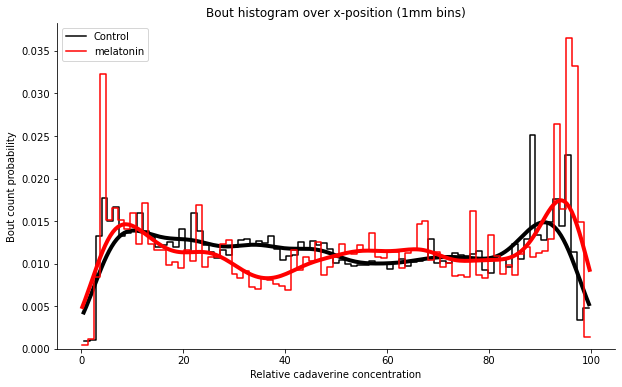

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data1 and data2 are pandas DataFrames
data1 = bout_rates_ctrl
data2 = bout_rates_SD

#convert x values to relative values for cadaverine concentration
preBout_1 = data1[3]
preBout_2=data2[3]
x_min = 330
x_max = 900
normalized_preBout_1 = (preBout_1 - x_min) / (x_max - x_min) * 100
normalized_preBout_2 = (preBout_2 - x_min) / (x_max - x_min) * 100;

# Create a figure
plt.figure(figsize=(10, 6))

# Plot both histograms using histplot
sns.histplot(data=data1, x=normalized_preBout_1, kde=True, bins=85,  color='black',element="step", fill=False, 
             label='Control',stat='probability',
            line_kws = dict(linewidth = 4))
sns.histplot(data=data2, x=normalized_preBout_2, kde=True, bins=85, color='red',element="step", fill=False,
             label='melatonin',stat='probability',
              line_kws = dict(linewidth = 4))

# Add labels and title
plt.ylabel("Bout count probability")
plt.xlabel("Relative cadaverine concentration")
plt.title("Bout histogram over x-position (1mm bins)")

#plt.ylim(0.0, 0.05)
# Add a legend to distinguish the two distributions
plt.legend()

# Remove the top and right spines for a cleaner look
sns.despine(right=True, bottom=False)

# Save or display the plot
#plt.savefig(r"E:\Olfaction\Prefernece_index_cadaverine\0mM_cad_control\return_point.pdf")
plt.show()


## Bout rates

bout rate difference calculated by substracting the bout rate 2cm close to odor source from the br far away from odor source.

bout rate = sum time/bout count *60

In [6]:
bout_rates_ctrl['bout_count'] = bout_rates_ctrl.index
print(bout_rates_ctrl)
bout_rates_SD['bout_count'] = bout_rates_SD.index
print(bout_rates_SD)

               0   1   2        3         4  bout_count
0      15.384615  15   1  333.654  1104.454           0
1      16.666667  15   1  333.778  1104.825           1
2       4.975124  15   1  333.786  1106.439           2
3      13.513514  15   1  333.667  1115.078           3
4       9.615385  15   1  333.739  1115.871           4
...          ...  ..  ..      ...       ...         ...
26129   2.570694  17  85  893.362   371.518       26129
26130   0.209600  17  85  896.037   454.507       26130
26131   0.086715  17  85  895.897   459.659       26131
26132   0.215843  17  85  897.571   471.517       26132
26133   1.406470  17  85  894.293   972.358       26133

[26134 rows x 6 columns]
              0   1   2        3        4  bout_count
0      1.436782  24   1  331.167   16.711           0
1      3.597122  24   1  331.167   19.590           1
2      0.694927  24   1  331.250   23.607           2
3      1.488095  24   1  331.250   28.045           3
4      1.811594  24   1  331.250

In [7]:
# Assume bout_rates_ctrl is your original DataFrame
# Rename columns for clarity
bout_rates_ctrl.columns = ['bout_rate', 'fish_number', 'bin_number', 'prebout_Xposition', 'prebout_time', 'bout_count']

#convert prebout times from seconds to minutes
bout_rates_ctrl['prebout_time_minutes'] = bout_rates_ctrl['prebout_time'] / 60
#print(bout_rates_ctrl)

# Define the cutoff for leftmost and rightmost bins
leftmost_bins = range(0, 20)
rightmost_bins = range(65,85)

# Separate data for leftmost and rightmost bins
left_bins_df_ctrl = bout_rates_ctrl[bout_rates_ctrl['bin_number'].isin(leftmost_bins)]
right_bins_df_ctrl = bout_rates_ctrl[bout_rates_ctrl['bin_number'].isin(rightmost_bins)]

# Calculate bout rate for left and right bins per fish
# Group by fish_number, calculate total bout_count and total time for each side, then compute bout rate
left_bout_rates_ctrl = left_bins_df_ctrl.groupby('fish_number').apply(lambda x: len(x['bout_count']) / 30).reset_index()
left_bout_rates_ctrl.columns = ['fish_number', 'bout_rate_left']  # Rename columns after reset_index
#print(left_bout_rates_ctrl)

right_bout_rates_ctrl = right_bins_df_ctrl.groupby('fish_number').apply(lambda x: len(x['bout_count']) / 30).reset_index()
right_bout_rates_ctrl.columns = ['fish_number', 'bout_rate_right']  # Rename columns after reset_index

#remove bout rates above 200 bouts/min as they are unrealistic
#left_bout_rates_ctrl = left_bout_rates_ctrl[left_bout_rates_ctrl['bout_rate_left'] <= 200]
#right_bout_rates_ctrl = right_bout_rates_ctrl[right_bout_rates_ctrl['bout_rate_right'] <= 200]

# Merge left and right bout rates for each fish
bout_rate_df_ctrl = pd.merge(left_bout_rates_ctrl, right_bout_rates_ctrl, on='fish_number')

# Calculate the difference: bout rate right - bout rate left
bout_rate_df_ctrl['bout_rate_difference'] = bout_rate_df_ctrl['bout_rate_right'] - bout_rate_df_ctrl['bout_rate_left']
print(bout_rate_df_ctrl)

# Calculate the mean bout rate difference across all fish
mean_bout_rate_difference_ctrl = bout_rate_df_ctrl['bout_rate_difference'].mean()
sem_bout_rate_difference_ctrl = sem(bout_rate_df_ctrl['bout_rate_difference'])


    fish_number  bout_rate_left  bout_rate_right  bout_rate_difference
0             2        9.266667        18.000000              8.733333
1             3        0.766667         8.233333              7.466667
2             4        9.600000         5.800000             -3.800000
3             5       12.433333        10.733333             -1.700000
4             6        3.100000         7.100000              4.000000
5             7       14.666667         8.733333             -5.933333
6             8       16.966667         7.500000             -9.466667
7             9        4.466667         7.533333              3.066667
8            10        1.466667         7.600000              6.133333
9            11        4.666667         8.166667              3.500000
10           12        5.933333        22.100000             16.166667
11           17        0.766667        20.566667             19.800000
12           18       14.100000         2.566667            -11.533333
13    

In [8]:
# Assume bout_rates_ctrl is your original DataFrame
# Rename columns for clarity
bout_rates_SD.columns = ['bout_rate', 'fish_number', 'bin_number', 'prebout_Xposition', 'prebout_time', 'bout_count']
#convert prebout times from seconds to minutes
bout_rates_SD['prebout_time_minutes'] = bout_rates_SD['prebout_time'] / 60
#print(bout_rates_SD)


# Define the cutoff for leftmost and rightmost bins
leftmost_bins = range(0, 20)
rightmost_bins = range(65,85)

# Separate data for leftmost and rightmost bins
left_bins_df_SD = bout_rates_SD[bout_rates_SD['bin_number'].isin(leftmost_bins)]
#print(left_bins_df_SD)
right_bins_df_SD = bout_rates_SD[bout_rates_SD['bin_number'].isin(rightmost_bins)]

# Calculate bout rate for left and right bins per fish
# Group by fish_number, calculate total bout_count and total time for each side, then compute bout rate
left_bout_rates_SD = left_bins_df_SD.groupby('fish_number').apply(lambda x: len(x['bout_count']) /30).reset_index()
print(left_bout_rates_SD)
left_bout_rates_SD.columns = ['fish_number', 'bout_rate_left']  # Rename columns after reset_index


right_bout_rates_SD = right_bins_df_SD.groupby('fish_number').apply(lambda x: len(x['bout_count']) / 30).reset_index()
right_bout_rates_SD.columns = ['fish_number', 'bout_rate_right']  # Rename columns after reset_index

#remove bout rates above 200 bouts/min as they are unrealistic
#left_bout_rates_ctrl = left_bout_rates_ctrl[left_bout_rates_ctrl['bout_rate_left'] <= 200]
#right_bout_rates_ctrl = right_bout_rates_ctrl[right_bout_rates_ctrl['bout_rate_right'] <= 200]


# Merge left and right bout rates for each fish
bout_rate_df_SD = pd.merge(left_bout_rates_SD, right_bout_rates_SD, on='fish_number')

# Calculate the difference: bout rate right - bout rate left
bout_rate_df_SD['bout_rate_difference'] = bout_rate_df_SD['bout_rate_right'] - bout_rate_df_SD['bout_rate_left']


# Calculate the mean bout rate difference across all fish
mean_bout_rate_difference_SD = bout_rate_df_SD['bout_rate_difference'].mean()
sem_bout_rate_difference_SD = sem(bout_rate_df_SD['bout_rate_difference'])


    fish_number          0
0             1   0.733333
1             2   6.833333
2             5  11.766667
3             6   8.533333
4             8   8.900000
5             9   8.766667
6            10  20.033333
7            11   2.633333
8            12   1.000000
9            13   0.100000
10           14   9.366667
11           17   3.733333
12           20   6.866667
13           21  11.400000
14           22  15.566667
15           23  18.300000
16           24   8.433333
17           25   1.266667
18           26  11.866667
19           27  18.233333
20           28   5.200000
21           29  24.033333
22           30   0.333333
23           32   3.833333
24           33   0.100000
25           35   0.200000


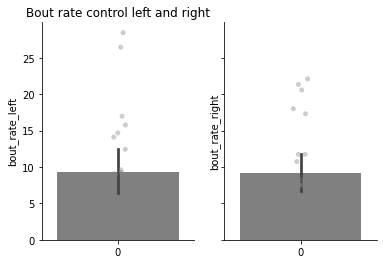

In [9]:
#a4_dims = (11.7, 8.27)
#fig, ax = plt.subplots(figsize=a4_dims)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax = sns.barplot(ax=ax1,y=left_bout_rates_ctrl['bout_rate_left'], color = "grey", orient="v")
ax = sns.stripplot(ax=ax1,data=left_bout_rates_ctrl['bout_rate_left'], dodge=True, color="grey", alpha = 0.4,jitter = 0.05)

ax = sns.barplot(ax=ax2, y=right_bout_rates_ctrl['bout_rate_right'], color = "grey", orient="v")
ax = sns.stripplot(ax=ax2,data=right_bout_rates_ctrl['bout_rate_right'], dodge=True, color="grey", alpha = 0.4,jitter = 0.05)

ax1.set_title("Bout rate control left and right")
#ax1.set_ylabel("Sleep min/h")
sns.despine(right=True, bottom=False)
#fig.savefig(r"E:\LIN\Acute_SD_Paper\Sleep_Deprivation\Results_October\Sleep_day1.pdf")

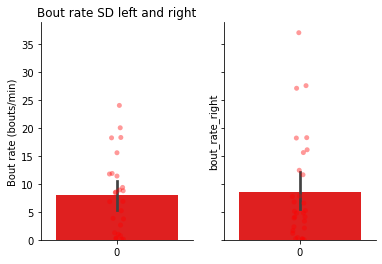

In [10]:
#a4_dims = (11.7, 8.27)
#fig, ax = plt.subplots(figsize=a4_dims)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax = sns.barplot(ax=ax1,y=left_bout_rates_SD['bout_rate_left'], color = "red", orient="v")
ax = sns.stripplot(ax=ax1,data=left_bout_rates_SD['bout_rate_left'], dodge=True, color="red", alpha = 0.4,jitter = 0.05)

ax = sns.barplot(ax=ax2, y=right_bout_rates_SD['bout_rate_right'], color = "red", orient="v")
ax = sns.stripplot(ax=ax2,data=right_bout_rates_SD['bout_rate_right'], dodge=True, color="red", alpha = 0.4,jitter = 0.05)

ax1.set_title("Bout rate SD left and right")
ax1.set_ylabel("Bout rate (bouts/min)")
sns.despine(right=True, bottom=False)
#fig.savefig(r"E:\LIN\Acute_SD_Paper\Sleep_Deprivation\Results_October\Sleep_day1.pdf")

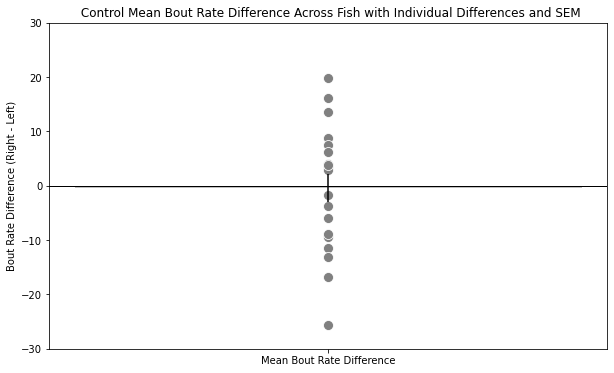

In [11]:
# Plotting
plt.figure(figsize=(10, 6))

# Bar plot: Mean bout rate difference across all fish with error bar for SEM
ax=sns.barplot(x=['Mean Bout Rate Difference'], y=[mean_bout_rate_difference_ctrl], color='grey', yerr=sem_bout_rate_difference_ctrl, alpha=0.5)

# Scatter plot overlay: Individual bout rate differences per fish
ax=sns.scatterplot(x=['Mean Bout Rate Difference'] * len(bout_rate_df_ctrl), y=bout_rate_df_ctrl['bout_rate_difference'], color='grey', s=100)

# Labels and title
plt.ylabel("Bout Rate Difference (Right - Left)")
plt.title(" Control Mean Bout Rate Difference Across Fish with Individual Differences and SEM")

plt.ylim(-30,30)
plt.axhline(y=0, color='black', linewidth=1, linestyle='-')  # Dashed line at y=0

#plt.savefig(r"E:\Olfaction\Prefernece_index_cadaverine\0mM_cad_control\boutrateDiff_ctrl.pdf")
plt.show()

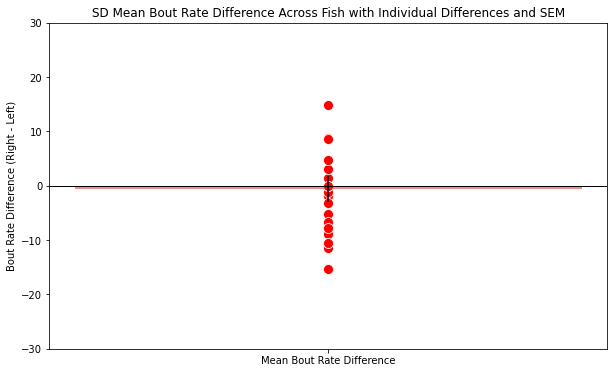

In [27]:
# Plotting
plt.figure(figsize=(10, 6))

# Bar plot: Mean bout rate difference across all fish with error bar for SEM

sns.barplot(x=['Mean Bout Rate Difference'], y=[mean_bout_rate_difference_SD], color='red', yerr=sem_bout_rate_difference_SD, alpha=0.5)

# Scatter plot overlay: Individual bout rate differences per fish

sns.scatterplot(x=['Mean Bout Rate Difference'] * len(bout_rate_df_SD), y=bout_rate_df_SD['bout_rate_difference'], color='red', s=100)

# Labels and title
plt.ylabel("Bout Rate Difference (Right - Left)")
plt.title("SD Mean Bout Rate Difference Across Fish with Individual Differences and SEM")

plt.ylim(-30,30)
plt.axhline(y=0, color='black', linewidth=1, linestyle='-')  # Dashed line at y=0

plt.savefig(r"E:\Olfaction\Prefernece_index_cadaverine\0mM_cad_control\boutrateDiff_SD.pdf")
plt.show()

In [28]:
# independent t-test
#control vs treatment
#p = ss.ttest_ind(bout_rate_df_ctrl['bout_rate_difference'], bout_rate_df_SD['bout_rate_difference'], equal_var=False)
#print("control vs treatment:", p)

p=ranksums(bout_rate_df_ctrl['bout_rate_difference'], bout_rate_df_SD['bout_rate_difference'])
print("control vs treatment:", p)

control vs treatment: RanksumsResult(statistic=0.5036862005093146, pvalue=0.614481907024343)
